### MechGPT chat interface

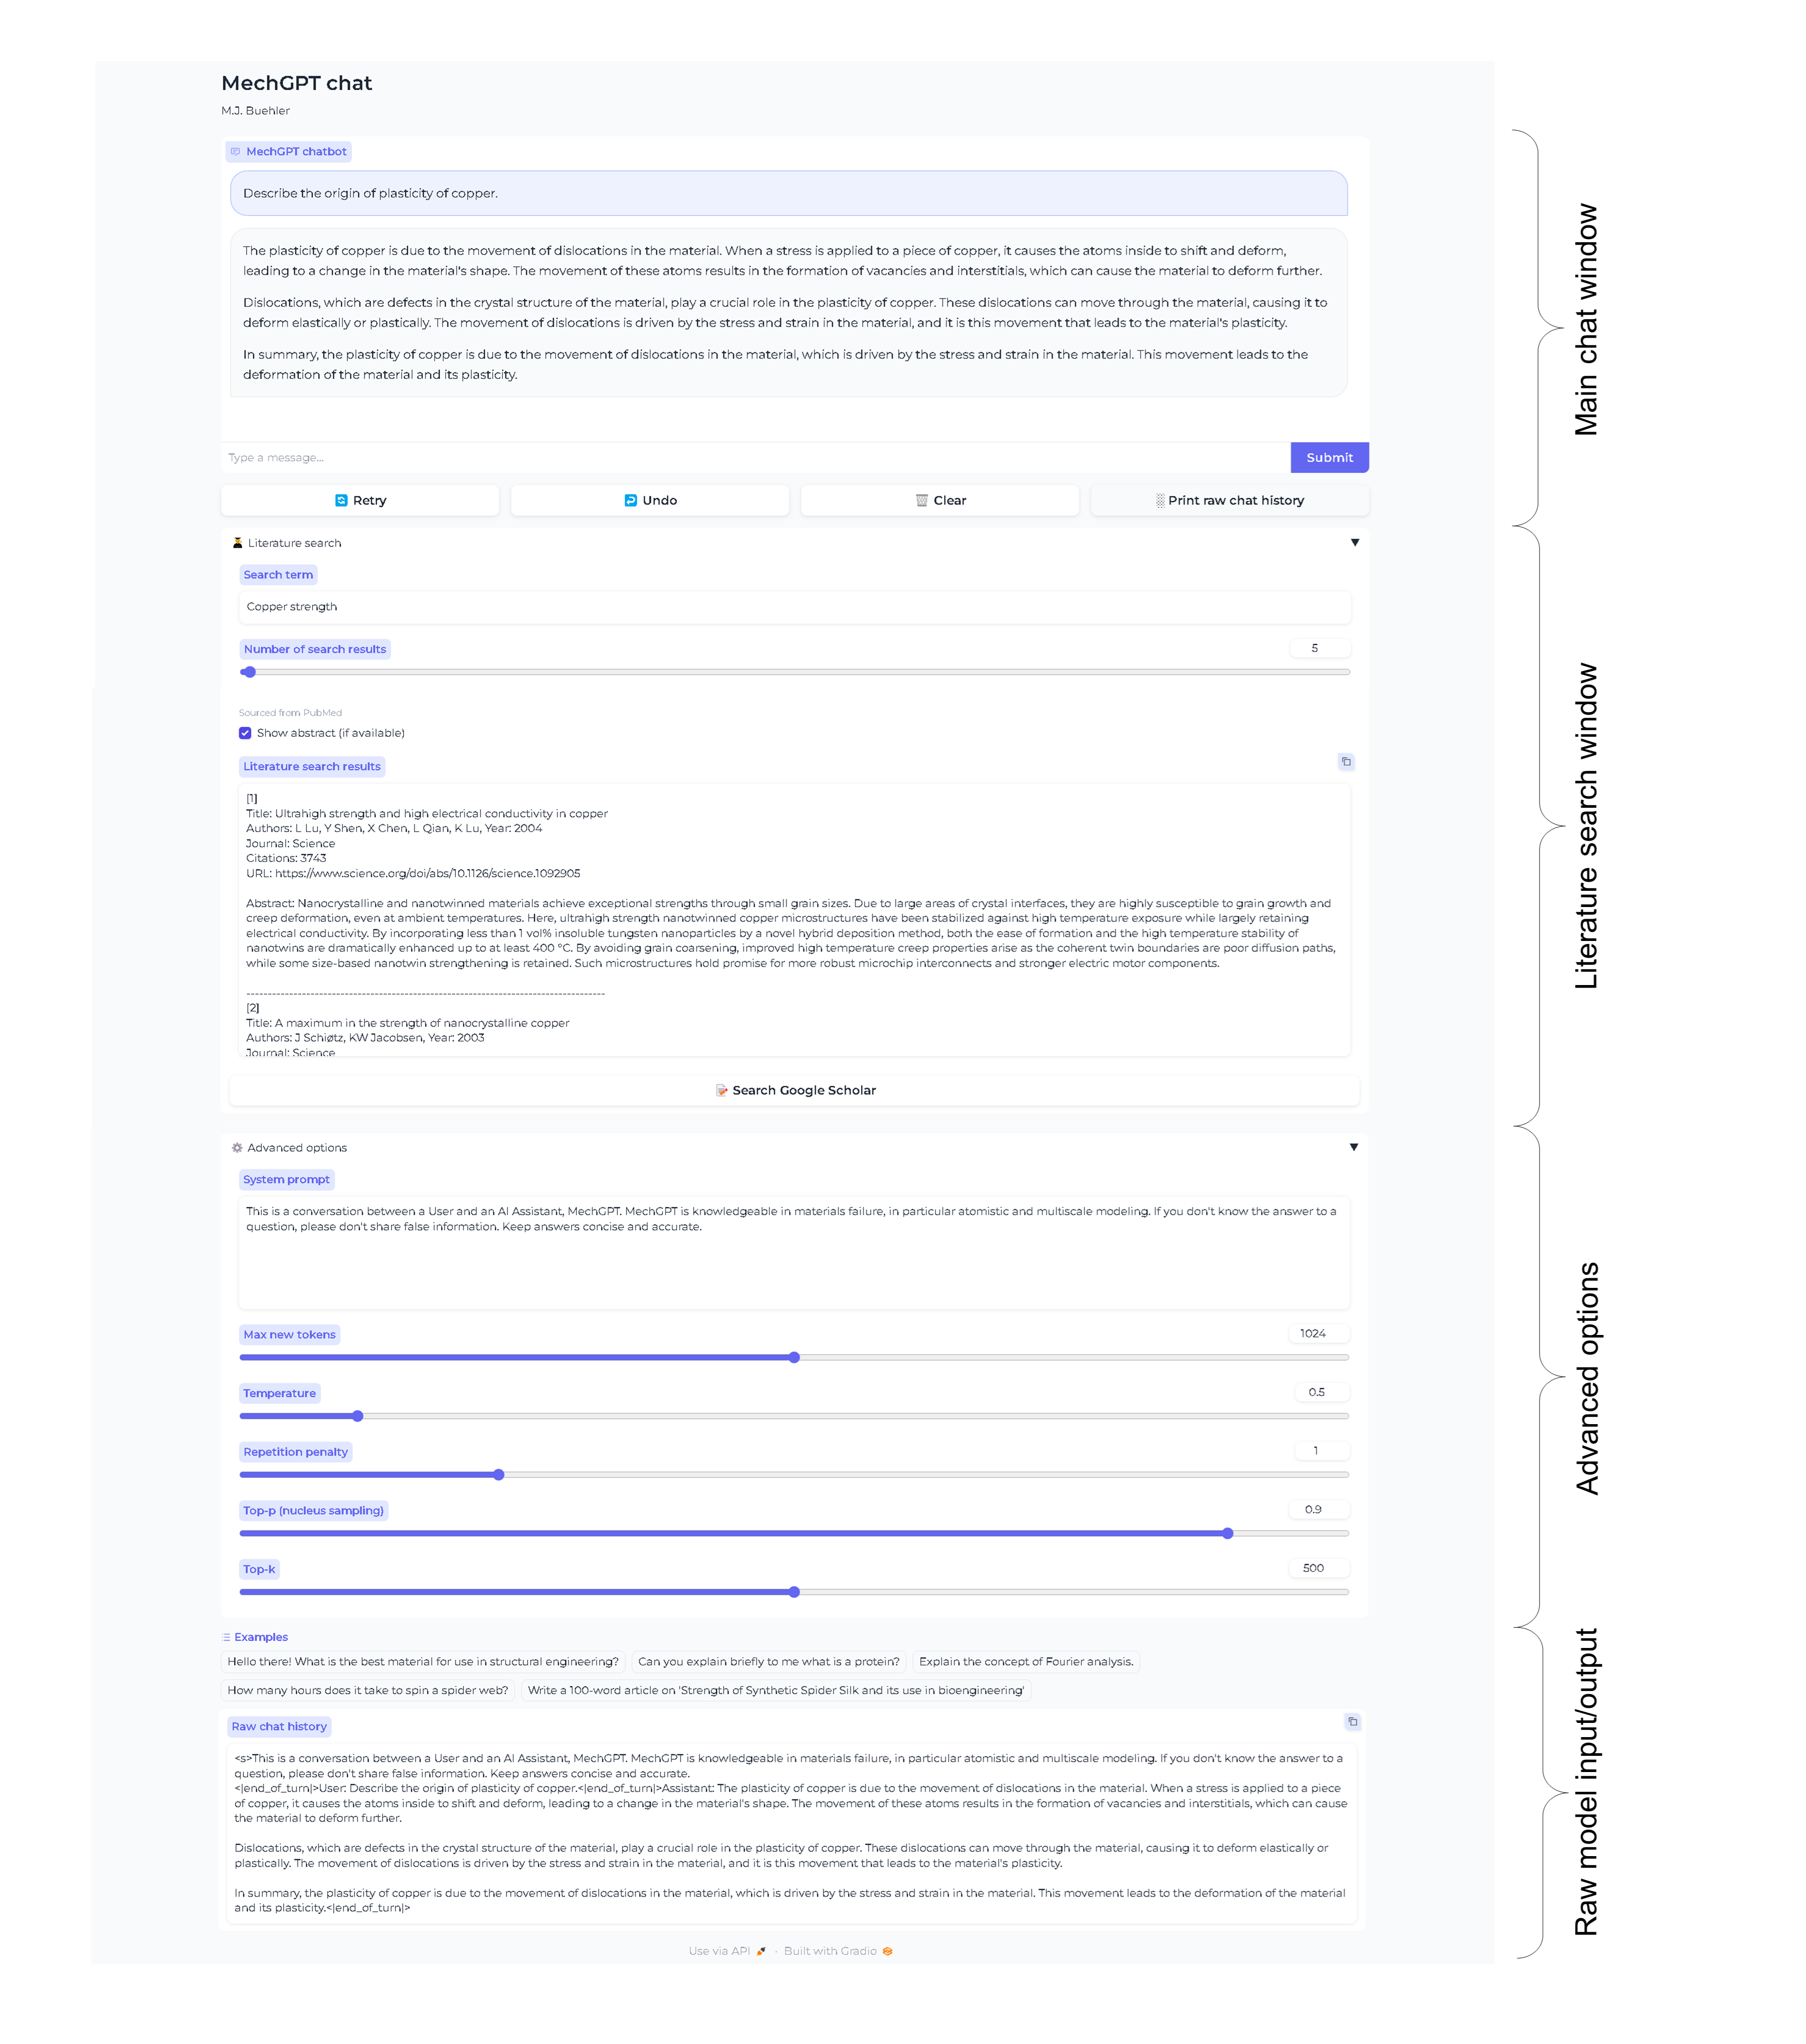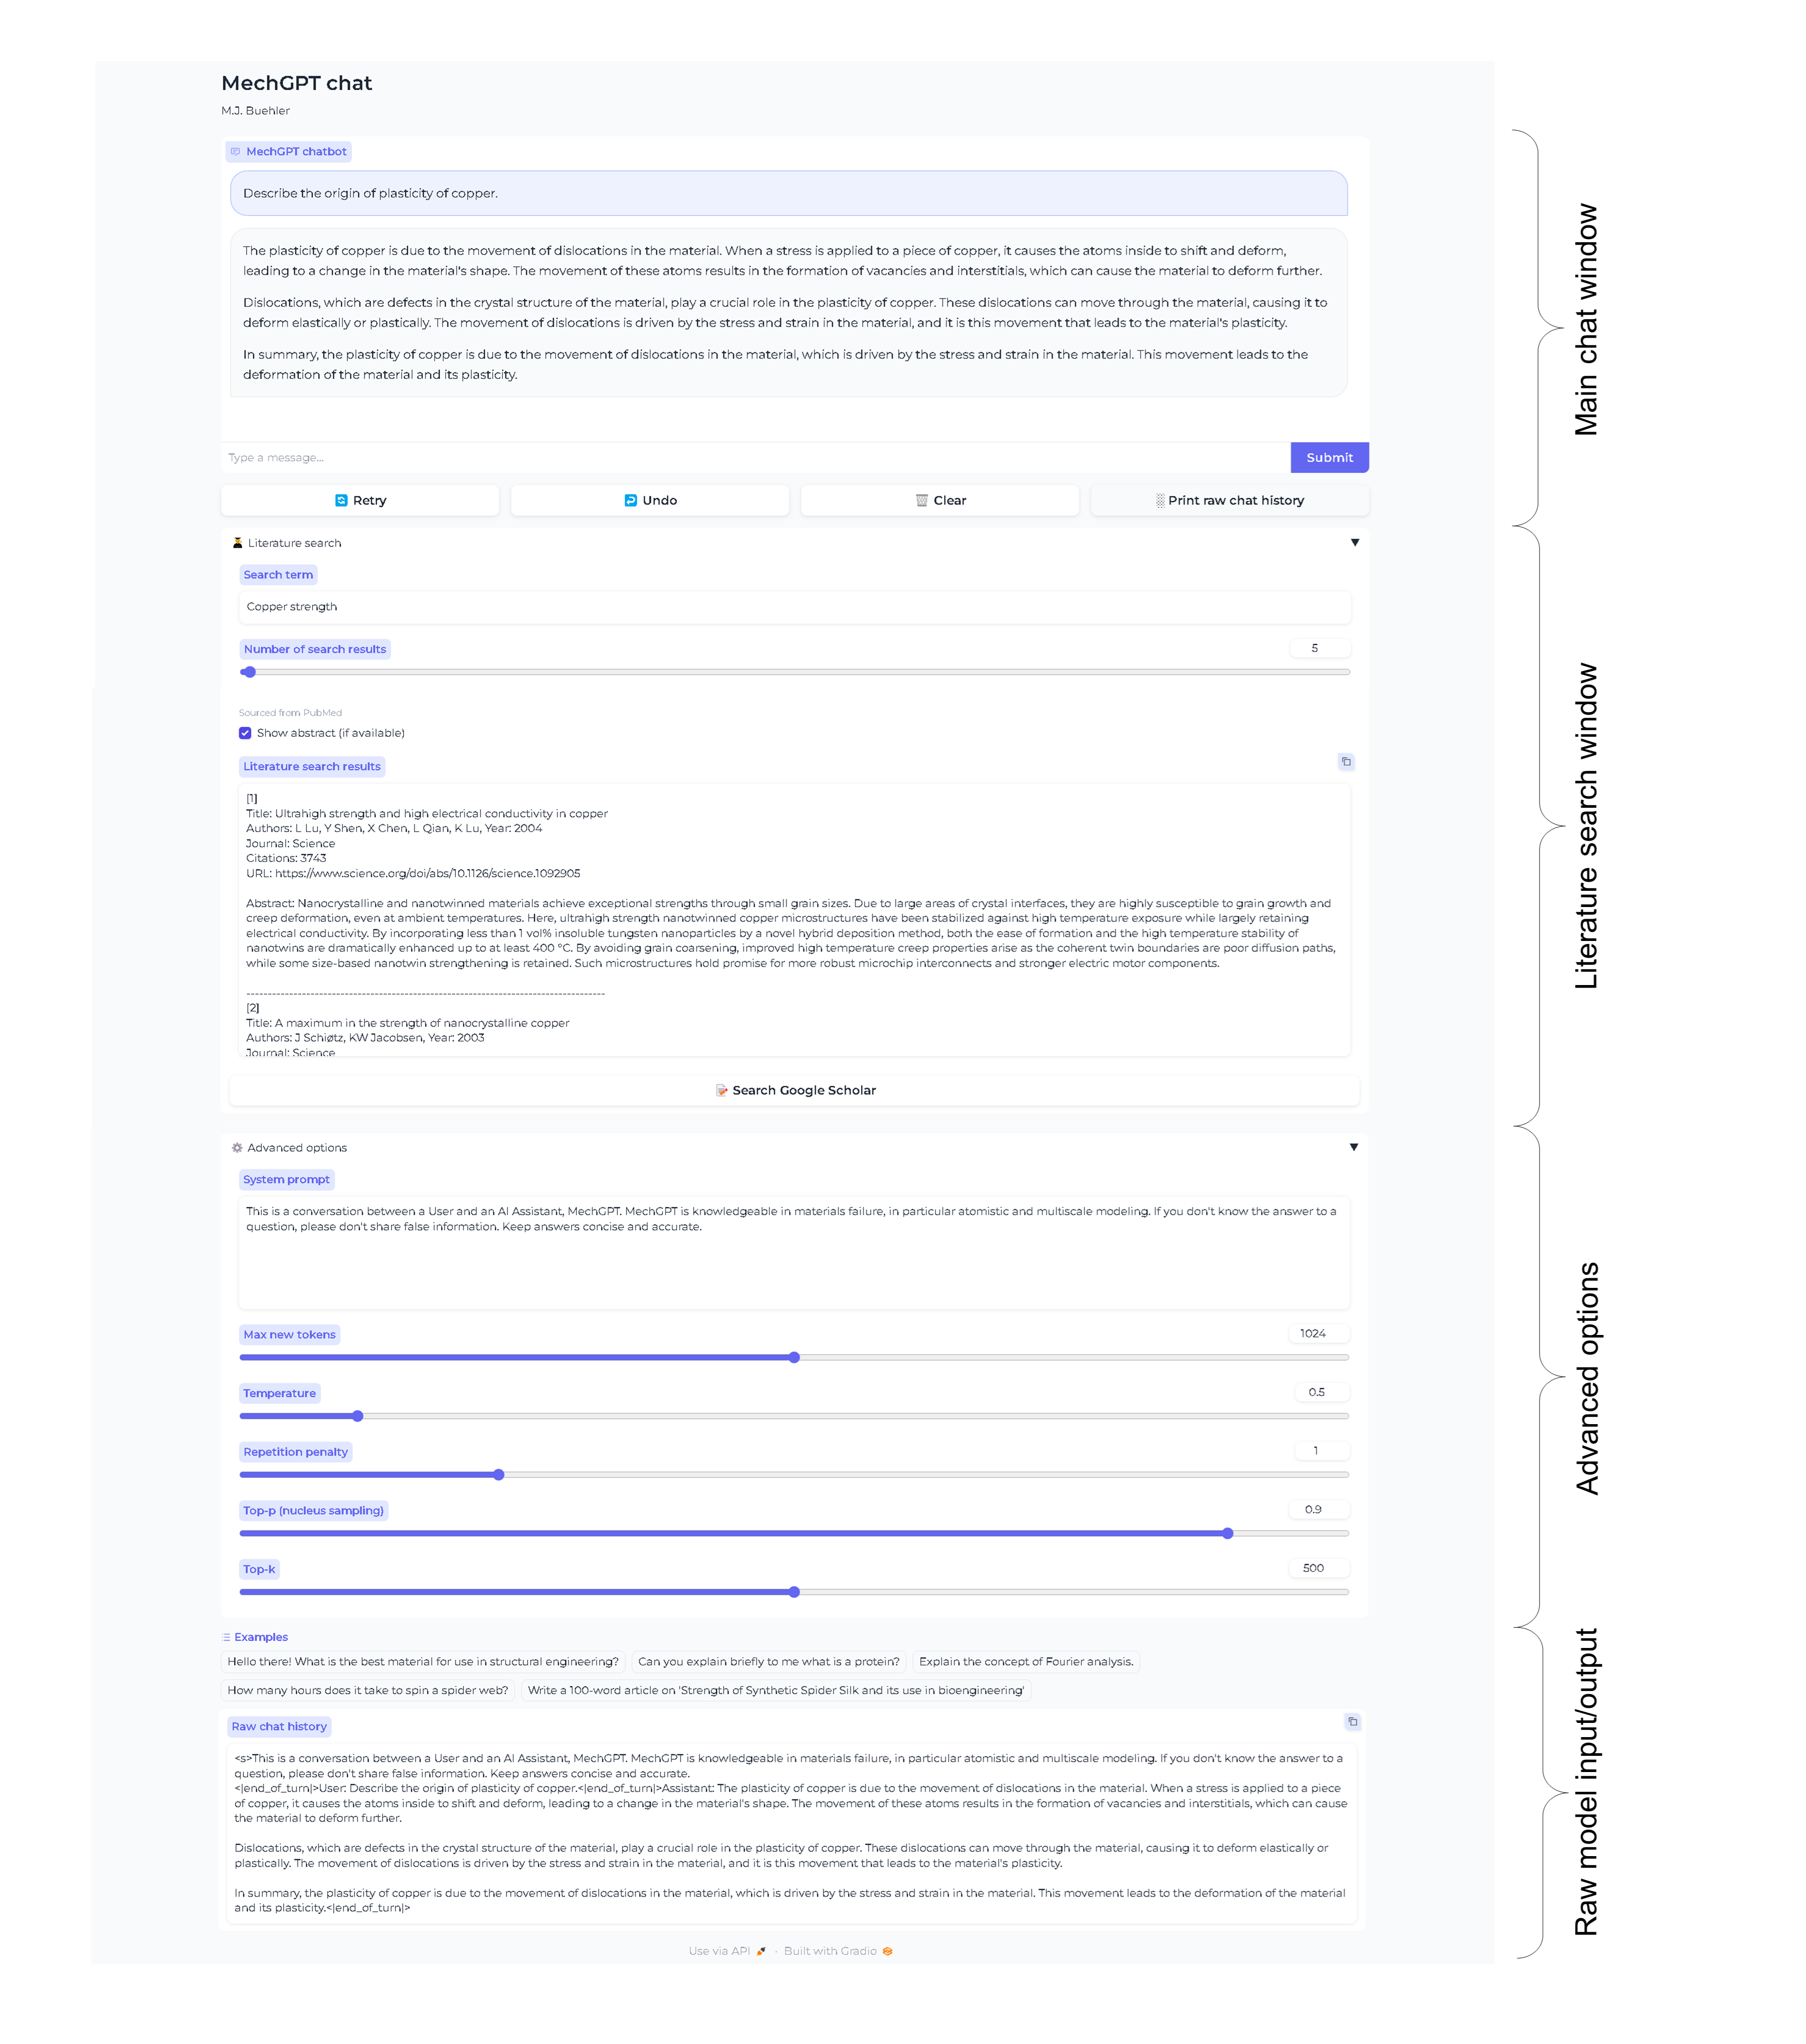

In [ ]:
from transformers import AutoModelForSeq2SeqLM
from peft import PeftModel, PeftConfig
from transformers import BitsAndBytesConfig
from transformers import AutoTokenizer, AutoModelForCausalLM
import transformers
import torch
import numpy as np
 
from threading import Thread
from typing import Iterator
from transformers import  TextIteratorStreamer

from transformers import GenerationConfig
import gradio as gr
 
from threading import Thread
from typing import Iterator
from transformers import AutoModelForCausalLM, AutoTokenizer, TextIteratorStreamer

model_name='Open-Orca/OpenOrca-Platypus2-13B'
FT_model_name = 'MechGPT-13b_v106C'

peft_model_id = f'{FT_model_name}'

In [ ]:
bnb_config4bit = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

tokenizer = AutoTokenizer.from_pretrained(model_name)
model_base = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    quantization_config= bnb_config4bit,
    torch_dtype=torch.bfloat16,
    trust_remote_code=True,
)

In [ ]:
model_base.config.use_cache = False
model = PeftModel.from_pretrained(model_base, peft_model_id, 
                             )
tokenizer = AutoTokenizer.from_pretrained(model_name)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right" 


### Chat interface 

In [ ]:
from transformers import StoppingCriteria, StoppingCriteriaList

class StoppingCriteriaSub(StoppingCriteria):

    def __init__(self, stops = [], encounters=1):
        super().__init__()
        self.stops = [stop.to("cuda") for stop in stops]

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor):
        for stop in self.stops:
            if torch.all((stop == input_ids[0][-len(stop):])).item():
                return True

        return False


stop_words = ["User:"  ]
stop_words_ids = [tokenizer(stop_word, add_special_tokens=False, return_tensors='pt')['input_ids'].squeeze() for stop_word in stop_words]
stopping_criteria = StoppingCriteriaList([StoppingCriteriaSub(stops=stop_words_ids)])

In [ ]:
stop_words_ids

In [ ]:
eos_token=[2, 32000]

from threading import Thread
from typing import Iterator
from transformers import  TextIteratorStreamer

from transformers import GenerationConfig
import gradio as gr
 

from typing import List
from typing import Tuple


import pymed
 
import json

pubmed = pymed.PubMed(tool="gradio_gscholar", email="markusjbuehler@gmail.com")


from threading import Thread
from typing import Iterator
from transformers import  TextIteratorStreamer

from transformers import GenerationConfig
import gradio as gr
 

from typing import List
from typing import Tuple


import scholarly
import io
import gradio as gr

def sort_by(a) -> bool:
    #return a["gsrank"]
    return a["num_citations"]

def get_papers(topic, lit_numpapers=10, show_abstract=False):

    pubs = list(map(lambda x: x[0], zip(scholarly.scholarly.search_pubs(topic), range(lit_numpapers ))))

    pubs = sorted(pubs, key=sort_by, reverse=True)
    i=0
    output = io.StringIO()
    for pub in pubs:
        i=i+1
       
        output.write(f'[{i}]\nTitle: {pub["bib"]["title"]}\n')
        output.write(f"Authors: {', '.join(filter(lambda x: len(x), pub['bib']['author']))}, Year: {pub['bib']['pub_year']}\n")
        output.write(f"Journal: {pub['bib']['venue']}\n")
        output.write(f"Citations: {pub['num_citations']}\n")
      
        output.write(f"URL: {pub['pub_url']}\n")
        
        if show_abstract:
            results = pubmed.query(pub["bib"]["title"])
            try:
                abstract = next(results).toDict()["abstract"]
            except StopIteration:
                abstract = "No abstract found"

            output.write(f"\nAbstract: {abstract}\n\n")

        output.write(f"------------------------------------------------------------------------------------\n")

    out = output.getvalue()
    output.close()

    return out

def get_prompt(message: str, chat_history: List[Tuple[str, str]],
               system_prompt: str,
             
              ) -> str:

    texts=[f'<s>{system_prompt}']
    
    do_strip = False
    for user_input, response in chat_history:
        user_input = user_input.strip() if do_strip else user_input
        do_strip = True
        texts.append(f'User: {user_input}<|end_of_turn|>Assistant: {response.strip()}<|end_of_turn|>')
    message = message.strip() if do_strip else message
    texts.append(f'User: {message}<|end_of_turn|>Assistant: ')
   
    return ''.join(texts) 

def get_input_token_length(message: str, chat_history: List[Tuple[str, str]], system_prompt: str,) -> int:
    prompt = get_prompt(message, chat_history, system_prompt,)
    input_ids = tokenizer([prompt], return_tensors='np', add_special_tokens=False)['input_ids']
    return input_ids.shape[-1]


def run(message: str,
        chat_history: List[Tuple[str, str]],
        system_prompt: str,
        max_new_tokens: int = 1024,
        temperature: float = 0.8,
        top_p: float = 0.95,
        top_k: int = 50,
        repetition_penalty = 1.,
       ) -> Iterator[str]:


    prompt = get_prompt(message, chat_history, system_prompt,
                       
                       )
    
    inputs = tokenizer([prompt], return_tensors='pt', 
                      ).to('cuda')

    streamer = TextIteratorStreamer(tokenizer,
                                    timeout=300.,
                                    skip_prompt=True,
                                    skip_special_tokens=True,
                                   )

    print (input)
    
    generate_kwargs = dict(
        inputs,
        streamer=streamer,
        max_new_tokens=max_new_tokens,
        do_sample=True,
        top_p=top_p,
        top_k=top_k,
        temperature=temperature, 
        eos_token_id=eos_token ,
        num_beams=1,
        repetition_penalty = repetition_penalty ,
        stopping_criteria=stopping_criteria,
      
    )
    t = Thread(target=model.generate, kwargs=generate_kwargs)
    t.start()

    outputs = []
    for text in streamer:
        outputs.append(text)
        
        yield ''.join(outputs).replace("###","").replace("##","").replace("[INST","")
    

"
DEFAULT_SYSTEM_PROMPT="This is a conversation between a User and an AI Assistant, MechGPT. \
MechGPT is knowledgeable in materials failure, in particular atomistic and multiscale modeling. \
If you don't know the answer to a question, please don't share false information. \
Keep answers concise and accurate.\
\n\n\
"

MAX_MAX_NEW_TOKENS = 2048
DEFAULT_MAX_NEW_TOKENS = 1024
MAX_INPUT_TOKEN_LENGTH = 4096 

DESCRIPTION = """
# MechGPT chat \n\nM.J. Buehler 
"""

LICENSE = """
<p/>
---
As a derivate work of [Llama-2-13b-chat](https://huggingface.co/meta-llama/Llama-2-13b-chat) by Meta, this model is governed by the original [license](https://huggingface.co/spaces/huggingface-projects/llama-2-7b-chat/blob/main/LICENSE.txt) and [acceptable use policy](https://huggingface.co/spaces/huggingface-projects/llama-2-7b-chat/blob/main/USE_POLICY.md).
"""

if not torch.cuda.is_available():
    DESCRIPTION += '\n<p>Running on CPU. This demo does not work on CPU.</p>'

def clear_and_save_textbox(message: str) -> Tuple[str, str]:
    return '', message


def display_input(message: str,
                  history: List[Tuple[str, str]]) -> List[Tuple[str, str]]:
    history.append((message, ''))
    return history

def print_raw(message: str,
                  chat_history: List[Tuple[str, str]],
             system_prompt: str) -> List[Tuple[str, str, str]]:

    prompt = get_prompt('', 
                        
                        chat_history, system_prompt,
                    
                       )
  
    return prompt
    

def delete_prev_fn(
        history: List[Tuple[str, str]]) -> Tuple[List[Tuple[str, str]], str]:
    try:
        message, _ = history.pop()
    except IndexError:
        message = ''
    return history, message or ''


def generate(
    message: str,
    history_with_input: List[Tuple[str, str]],
    system_prompt: str,
    max_new_tokens: int,
    temperature: float,
    top_p: float,
    top_k: int,
    repetition_penalty: float,

) -> Iterator[List[Tuple[str, str]]]:
    if max_new_tokens > MAX_MAX_NEW_TOKENS:
        raise ValueError

    history = history_with_input[:-1]
    generator = run(message, history, system_prompt, max_new_tokens, temperature, top_p, top_k, repetition_penalty)
    try:
        first_response = next(generator)
        yield history + [(message, first_response)]
    except StopIteration:
        yield history + [(message, '')]
    for response in generator:
        yield history + [(message, response)]


def process_example(message: str) -> Tuple[str, List[Tuple[str, str]]]:
    generator = generate(message, [], DEFAULT_SYSTEM_PROMPT, 1024, 1, 0.95, 50, 1.,
                        # False,
                        )
    for x in generator:
        pass
    return '', x


def check_input_token_length(message: str, chat_history: List[Tuple[str, str]], system_prompt: str) -> None:
    input_token_length = get_input_token_length(message, chat_history, system_prompt, )
    if input_token_length > MAX_INPUT_TOKEN_LENGTH:
        raise gr.Error(f'The accumulated input is too long ({input_token_length} > {MAX_INPUT_TOKEN_LENGTH}). Clear your chat history and try again.')

    return input_token_length

CSS ="""
.contain { display: flex; flex-direction: column; }
.gradio-container { height: 100vh !important; }
#component-0 { height: 100%; }
#chatbot { flex-grow: 1; overflow: auto; resize: vertical; }
"""

with gr.Blocks(gr.themes.Soft(),   
    
       font=[gr.themes.GoogleFont("Inconsolata"), "Arial", "sans-serif"]
              ) as demo:
    gr.Markdown(DESCRIPTION)
   


    with gr.Group():
        chatbot = gr.Chatbot(label='MechGPT chatbot')
        with gr.Row():
            textbox = gr.Textbox(
                container=False,
                show_label=False,
                placeholder='Type a message...',
                scale=20,
            )
            submit_button = gr.Button('Submit',
                                      variant='primary',
                                      scale=1,
                                      min_width=0)



    
    with gr.Row():
        retry_button = gr.Button('🔄  Retry', variant='secondary')
        undo_button = gr.Button('↩️ Undo', variant='secondary')
        clear_button = gr.Button('🗑️  Clear', variant='secondary')
        input_token_length = gr.Number(value=0, label='Tokens used' )
        chathistory_button = gr.Button('░ Print raw chat history', variant='tertiary')
        
        

    saved_input = gr.State()

  
    with gr.Accordion(label='🧑‍🎓 Literature search', open=False):
        
        search_term=gr.Textbox( label = 'Search term'  )
        slider_2 = gr.Slider(minimum=1, maximum=1024, step=1, value=10,label="Number of search results", 
                            )
        
        show_abstract = gr.Checkbox(label="Show abstract (if available)", 
                                    info="Sourced from PubMed"
                                   )
        
        txt_3 = gr.Textbox(value="", label="Literature search results", 
                           show_copy_button=True, max_lines=16)
        btn = gr.Button(value="📝 Search Google Scholar", variant = 'secondary')
        btn.click(get_papers, inputs=[search_term, slider_2, show_abstract], outputs=[txt_3])

        
        
    with gr.Accordion(label='⚙️ Advanced options', open=False):
        system_prompt = gr.Textbox(label='System prompt',
                                   value=DEFAULT_SYSTEM_PROMPT,
                                   lines=6)
        max_new_tokens = gr.Slider(
            label='Max new tokens',
            minimum=1,
            maximum=MAX_MAX_NEW_TOKENS,
            step=1,
            value=DEFAULT_MAX_NEW_TOKENS,
        )
        temperature = gr.Slider(
            label='Temperature',
            minimum=0.1,
            maximum=4.0,
            step=0.1,
            value=.5,
        )
        repetition_penalty = gr.Slider(
            label='Repetition penalty',
            minimum=0.1,
            maximum=4.0,
            step=0.1,
            value=1.,
        )

        top_p = gr.Slider(
            label='Top-p (nucleus sampling)',
            minimum=0.05,
            maximum=1.0,
            step=0.05,
            value=0.9,
        )
        top_k = gr.Slider(
            label='Top-k',
            minimum=1,
            maximum=1000,
            step=1,
            value=500,
        )
        '''
        add_special = gr.Checkbox(
            label='Optional checkbox for future use',
            #minimum=1,
            #maximum=1000,
            #step=1,
            value=add_special_default,
        )
        '''
    gr.Examples(
        examples=['Who was Albert Einstein?', 'What is hyperelasticity?'],
         
        
        inputs=textbox,
        outputs=[textbox, chatbot],
        fn=process_example,
        cache_examples=False, #True,
    )

    button_event_preprocess = submit_button.click(
        fn=clear_and_save_textbox,
        inputs=textbox,
        outputs=[textbox, saved_input],
        api_name=False,
        queue=False,
    ).then(
        fn=display_input,
        inputs=[saved_input, chatbot],
        outputs=chatbot,
        api_name=False,
        queue=False,
    ).then(
        fn=check_input_token_length,
        inputs=[saved_input, chatbot, system_prompt],
        outputs=input_token_length,
        api_name=False,
        queue=False,
    ).success(
        fn=generate,
        inputs=[
            saved_input,
            chatbot,
            system_prompt,
            max_new_tokens,
            temperature,
            top_p,
            top_k,
            repetition_penalty,
          
        ],
        outputs=chatbot,
        api_name=False,
    )
    chathistory = gr.Textbox(value="", label="Show raw chat history", 
                           show_copy_button=True, )
    chathistory_button_proess=chathistory_button.click (
                            fn=print_raw,
                            inputs=[ saved_input, 
                                    chatbot, system_prompt],
                            outputs = [chathistory],
        
        api_name=False,
        queue=False,
    )   
        
        
    
    retry_button.click(
        fn=delete_prev_fn,
        inputs=chatbot,
        outputs=[chatbot, saved_input],
        api_name=False,
        queue=False,
    ).then(
        fn=display_input,
        inputs=[saved_input, chatbot],
        outputs=chatbot,
        api_name=False,
        queue=False,
    ).then(
        fn=generate,
        inputs=[
            saved_input,
            chatbot,
            system_prompt,
            max_new_tokens,
            temperature,
            top_p,
            top_k,
            repetition_penalty,
           
        ],
        outputs=chatbot,
        api_name=False,
    )

    undo_button.click(
        fn=delete_prev_fn,
        inputs=chatbot,
        outputs=[chatbot, saved_input],
        api_name=False,
        queue=False,
    ).then(
        fn=lambda x: x,
        inputs=[saved_input],
        outputs=textbox,
        api_name=False,
        queue=False,
    )

    clear_button.click(
        fn=lambda: ([], ''),
        outputs=[chatbot, saved_input],
        queue=False,
        api_name=False,
    )

demo.queue(max_size=1).launch(height=900, share=True, 
                              
                              debug=True)